# Data clustering
Here we are trying to separate cells in our data into 4 categories based on Ch2 and Ch3 mean values:
- Ch2 positive
- Ch3 positive
- Double positive
- Double negative

## KMeans
Performing a 2D KMeans clustering results in 4 acceptable clusters. However one cluster is hard to interpret as it is not really falling into our 4 categories as described.

Performing a 1D KMeans clustering for Ch2 and Ch3 separately results into decent separation, giving acceptable threshold for each channel independently.

## Automatic thresholding
Finding threshold for each channel separately, can be compared to thresholding each image automatically using common algorithms (such as Otsu). In fact, Otsu thresholding can be done on the histogram of all data points together instead of each image separately. In this way, the data which was made comparable by background subtraction can be pooled together and Otsu can be used to identify Ch2 and Ch3 thresholds. These values are actually very similar to the values obtained with 1D KMeans.

In [2]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from skimage.filters import threshold_otsu, threshold_li, threshold_minimum, threshold_mean, threshold_yen, threshold_triangle, threshold_isodata

In [3]:
# Define paths
data_path = "../../../Output/Measurements/"
output_path = "../../../Output/Figures/"

# read in data
df = (pd.read_csv(data_path + 'measurements_all.csv')
    .assign(condition = lambda df_: df_.condition.astype('category'),
            bio_replicate = lambda df_: df_.bio_replicate.astype('category'))
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60020 entries, 0 to 60019
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Image                   60020 non-null  object  
 1   Channel 2: Mean         60020 non-null  float64 
 2   Channel 3: Mean         60020 non-null  float64 
 3   Channel 2: Mean_bkg_C2  60020 non-null  float64 
 4   Channel 3: Mean_bkg_C3  60020 non-null  float64 
 5   Centroid X µm           60020 non-null  float64 
 6   Centroid Y µm           60020 non-null  float64 
 7   ch2_bg_sub              60020 non-null  float64 
 8   ch3_bg_sub              60020 non-null  float64 
 9   date                    60020 non-null  object  
 10  project                 60020 non-null  object  
 11  plasmid_number          60020 non-null  int64   
 12  female_number           60020 non-null  object  
 13  embryo_number           60020 non-null  int64   
 14  slide_number          

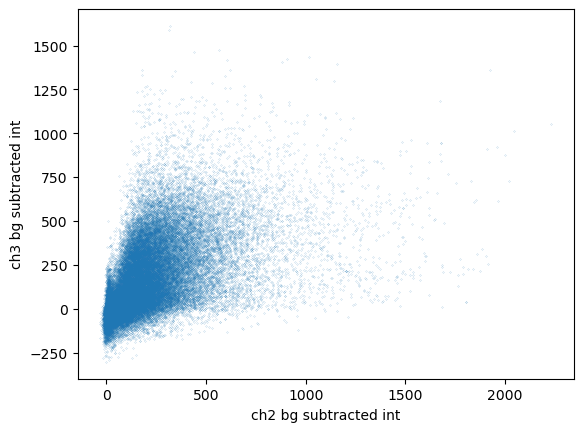

In [4]:
# Scatterplot of all points to see distribution
sns.reset_defaults()
X = df[['ch2_bg_sub', 'ch3_bg_sub']].to_numpy()

plt.scatter(X[:,0], X[:,1], s=0.01)
plt.xlabel('ch2 bg subtracted int')
plt.ylabel('ch3 bg subtracted int')
plt.show()

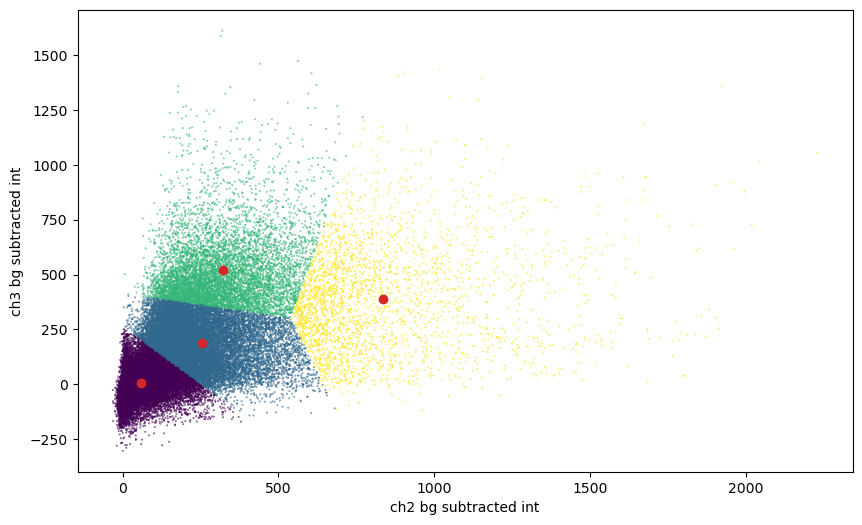

In [5]:
# perform KMeans with 4 clusters
num_cluster = 4
k_means = KMeans(num_cluster)
k_means.fit(X)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1], s=0.1, c=k_means.labels_)
plt.scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1], c='tab:red')

plt.xlabel('ch2 bg subtracted int')
plt.ylabel('ch3 bg subtracted int')
plt.show()

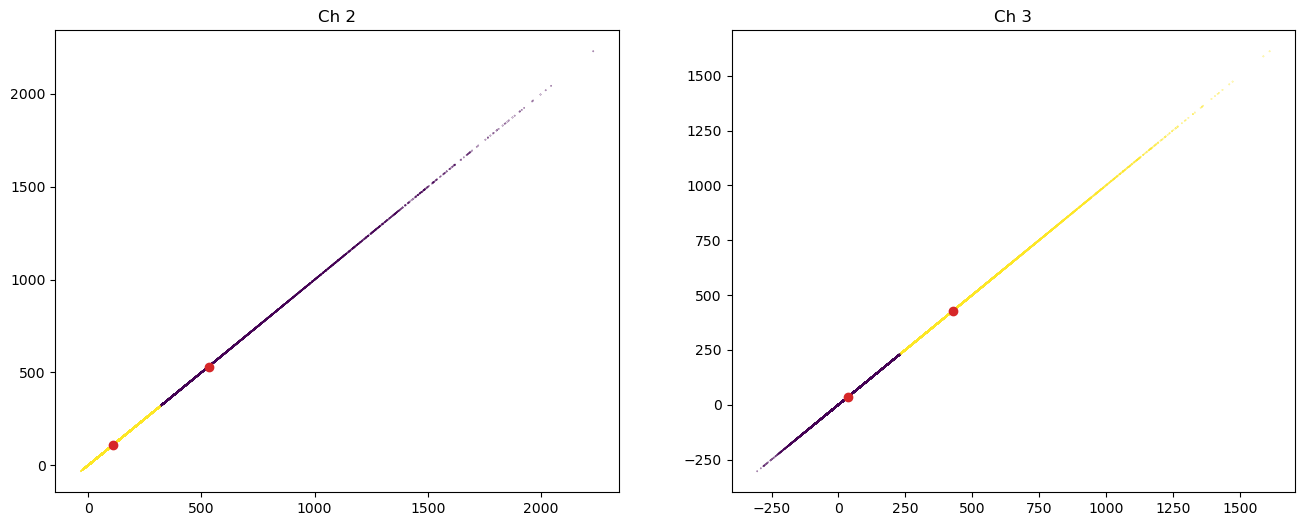

In [6]:
# Perform 1D KMeans on Ch2 and Ch3 independently
X = df[['ch2_bg_sub']].to_numpy()

num_cluster = 2
k_means = KMeans(num_cluster)
k_means.fit(X)

f, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(X[:,0], X[:,0], s=0.05, c=k_means.labels_)
axes[0].scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,0], c='tab:red')
axes[0].set_title('Ch 2')

X = df[['ch3_bg_sub']].to_numpy()

num_cluster = 2
k_means = KMeans(num_cluster)
k_means.fit(X)

axes[1].scatter(X[:,0], X[:,0], s=0.05, c=k_means.labels_)
axes[1].scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,0], c='tab:red')
axes[1].set_title('Ch 3')
plt.show()

In [7]:
# Compare thresholding on all datapoints Ch2 and Ch3 separately
threshold_functions = [threshold_otsu, threshold_li, threshold_minimum, threshold_mean, threshold_yen, threshold_triangle, threshold_isodata]
colors = sns.color_palette('tab10', len(threshold_functions))

sns.set(style='darkgrid')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.hist(df[['ch2_bg_sub']].to_numpy(), bins=100, alpha=0.8, color='olive')
for idx, (thresh, color) in enumerate(zip(threshold_functions, colors)):
    ax1.axvline(thresh(df[['ch2_bg_sub']].to_numpy()), c=color)
    ax1.text(x=thresh(df[['ch2_bg_sub']].to_numpy()), y=1 + (idx * 80), s=thresh.__name__.split('_')[-1], c=color, rotation=90)
ax1.set_title("Channel 2")
ax1.set_yscale('log')

ax2.hist(df[['ch3_bg_sub']], bins=100, alpha=0.8, color='olive')
for idx, (thresh, color) in enumerate(zip(threshold_functions, colors)):
    ax2.axvline(thresh(df[['ch3_bg_sub']].to_numpy()), c=color)
    ax2.text(x=thresh(df[['ch3_bg_sub']].to_numpy()), y=1 + (idx * 80), s=thresh.__name__.split('_')[-1], c=color, rotation=90)
ax2.set_title("Channel 3")
ax2.set_yscale('log')
plt.savefig(output_path + 'histogram_threshold_comparison.pdf')
plt.show()

In [133]:
threshold_functions = [threshold_li, threshold_otsu, threshold_triangle, threshold_isodata]
choices = [1,2,3,4]

for thresh in threshold_functions:
    # Get thresholding values
    ch2_thresh = thresh(df['ch2_bg_sub'].to_numpy())
    ch3_thresh = thresh(df['ch3_bg_sub'].to_numpy())

    print(thresh.__name__.split('_')[-1], 'ch2', ch2_thresh)
    print(thresh.__name__.split('_')[-1], 'ch3', ch3_thresh)

    # Define conditions for the classes
    conditions = [
        df['ch2_bg_sub'].gt(ch2_thresh) & df['ch2_bg_sub'].lt(ch3_thresh),
        df['ch3_bg_sub'].gt(ch3_thresh) & df['ch2_bg_sub'].lt(ch2_thresh),
        df['ch3_bg_sub'].gt(ch3_thresh) & df['ch2_bg_sub'].gt(ch2_thresh),
        df['ch3_bg_sub'].lt(ch3_thresh) & df['ch2_bg_sub'].lt(ch2_thresh)
    ]

    # map conditions to actual dataframe
    df['category_' + thresh.__name__.split('_')[-1]] = np.select(conditions, choices, default=1)
# Save categorized data to disk
df.to_csv(data_path + "measurements_classification.csv", index=False)

df

li ch2 197.48730164722554
li ch3 185.96092069921883
otsu ch2 317.0325416015625
otsu ch3 231.41744882812498
triangle ch2 396.5435865234375
triangle ch3 134.16913085937497
isodata ch2 308.1979810546875
isodata ch3 223.93680898437498


Image  Channel 2: Mean  \
0      2022_11_04_OEvariants_RBMX_693_E18_12_SLIDE01_...          51.9525   
1      2022_11_04_OEvariants_RBMX_693_E18_12_SLIDE01_...          92.7944   
2      2022_11_04_OEvariants_RBMX_693_E18_12_SLIDE01_...          69.4266   
3      2022_11_04_OEvariants_RBMX_693_E18_12_SLIDE01_...          59.3333   
4      2022_11_04_OEvariants_RBMX_693_E18_12_SLIDE01_...          73.1285   
...                                                  ...              ...   
60015  2023_02_07_OE_RBMXL1_819_E05_05_SLIDE01_GFP_KI...         146.8158   
60016  2023_02_07_OE_RBMXL1_819_E05_05_SLIDE01_GFP_KI...         115.6216   
60017  2023_02_07_OE_RBMXL1_819_E05_05_SLIDE01_GFP_KI...          54.4375   
60018  2023_02_07_OE_RBMXL1_819_E05_05_SLIDE01_GFP_KI...         147.5333   
60019  2023_02_07_OE_RBMXL1_819_E05_05_SLIDE01_GFP_KI...         271.6552   

       Channel 3: Mean  Channel 2: Mean_bkg_C2  Channel 3: Mean_bkg_C3  \
0              82.3525                 22.7945                 63.4412   
1             137.4188                 22.7945                 63.4412   
2              95.4915                 22.7945                 63.4412   
3              60.0560                 22.7945                 63.4412   
4              74.5925                 22.7945                 63.4412   
...                ...                     ...                     ...   
60015         335.1842                 24.3444                 52.9434   
60016          83.3243                 24.3444                 52.9434   
60017          79.5312                 24.3444                 52.9434   
60018         242.4333                 24.3444                 52.9434   
60019         233.3793                 24.3444                 52.9434   

       Centroid X µm  Centroid Y µm  ch2_bg_sub  ch3_bg_sub        date  ...  \
0             502.83         493.06     29.1580     18.9113  2022-11-04  ...   
1             464.97         494.98     69.9999     73.9776  2022-11-04  ...   
2             477.84         528.83     46.6321     32.0503  2022-11-04  ...   
3             561.68         566.96     36.5388     -3.3852  2022-11-04  ...   
4             487.74         596.04     50.3340     11.1513  2022-11-04  ...   
...              ...            ...         ...         ...         ...  ...   
60015         594.57         627.50    122.4714    282.2408  2023-02-07  ...   
60016         639.38         552.00     91.2772     30.3809  2023-02-07  ...   
60017         418.79         527.72     30.0931     26.5878  2023-02-07  ...   
60018         587.16         616.93    123.1889    189.4899  2023-02-07  ...   
60019         493.05         611.28    247.3108    180.4359  2023-02-07  ...   

      ch1_target  ch2_target ch3_target  ch4_target bio_replicate condition  \
0            GFP        KI67       PAX6        DAPI             3         3   
1            GFP        KI67       PAX6        DAPI             3         3   
2            GFP        KI67       PAX6        DAPI             3         3   
3            GFP        KI67       PAX6        DAPI             3         3   
4            GFP        KI67       PAX6        DAPI             3         3   
...          ...         ...        ...         ...           ...       ...   
60015        GFP        KI67       PAX6        DAPI             1        12   
60016        GFP        KI67       PAX6        DAPI             1        12   
60017        GFP        KI67       PAX6        DAPI             1        12   
60018        GFP        KI67       PAX6        DAPI             1        12   
60019        GFP        KI67       PAX6        DAPI             1        12   

      category_li category_otsu category_triangle category_isodata  
0               4             4                 4                4  
1               4             4                 4                4  
2               4             4                 4                4  
3               4             4                 4  

In [125]:
# Visualize the established categorization
sns.set(context='talk')
f, axes = plt.subplots(1, len(threshold_functions), figsize=(20,4))
for ax, thresh in zip(axes.ravel(), threshold_functions):
    ax.scatter(df['ch2_bg_sub'], df['ch3_bg_sub'], s=2, c=df['category_' + thresh.__name__.split('_')[-1]], cmap='tab10', alpha=0.6)
    ax.set_title(thresh.__name__.split('_')[-1])
plt.tight_layout()
plt.show()